In [17]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time

import numpy as np
import matplotlib.pyplot as plt

import sys, os

import moyra as ma
import moyra.elements as ele
import moyra.forces as ef

me.mechanics_printing()

#### Create Symbols

In [18]:
from sympy.abc import x,y,z
DoFs = 6          # total degrees of freedom

p = ma.DynamicModelParameters(DoFs)

p.m = ma.ModelSymbol(string = 'm')
p.I_xx = ma.ModelSymbol(string = 'I_xx')
p.I_yy = ma.ModelSymbol(string = 'I_yy')
p.I_zz = ma.ModelSymbol(string = 'I_zz')

p.Fx = ma.ModelSymbol(string = 'Fx')
p.Fy = ma.ModelSymbol(string = 'Fy')
p.Fz = ma.ModelSymbol(string = 'Fz')
p.Mx = ma.ModelSymbol(string = 'Mx')
p.My = ma.ModelSymbol(string = 'My')
p.Mz = ma.ModelSymbol(string = 'Mz')

# Attitude Parmas
p.g  = ma.ModelSymbol(value = 9.81,string = 'g')                     # gravity

#### Create Coordinate Systems

In [52]:
wind_frame = ma.HomogenousTransform().Translate(p.q[0],p.q[1],p.q[2])
wind2body = ma.HomogenousTransform().R_x(p.q[3]).R_z(p.q[5]).R_y(p.q[4])
body_frame = wind_frame * wind2body
# tether2body = ma.HomogenousTransform().R_x(p.q[2]).R_z(p.q[4]).R_y(p.q[3])
# body_frame = (tether_frame*tether2body).simplify()
#Generate Mass Matrices
M = ele.MassMatrix(p.m, I_xx = p.I_xx, I_yy=p.I_yy, I_zz=p.I_zz)

# Generate Rigid Elements
aircraft_mass = ele.RigidElement(body_frame,M,gravityPotential=True, simplify=True)
#tether_spring = ele.Spring(p.q[2],p.K)

In [53]:
# Generate Aircraft external forces
aircraft_forces = ef.BodyForce(p,body_frame,Fx=p.Fx,Fy=p.Fy,Fz=p.Fz,Mx=p.Mx,My=p.My,Mz=p.Mz)

In [54]:
sm = ma.SymbolicModel.FromElementsAndForces(p,[aircraft_mass],ExtForces=aircraft_forces)

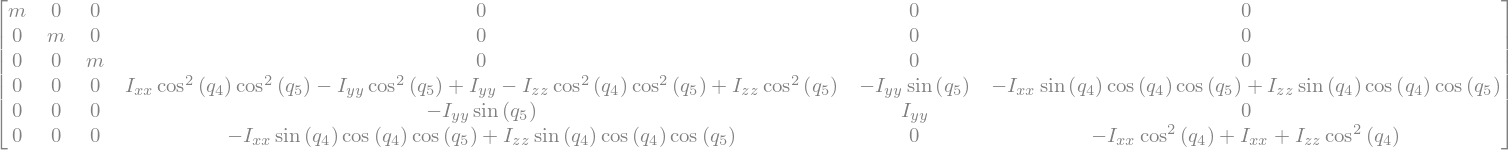

In [55]:
sm.M

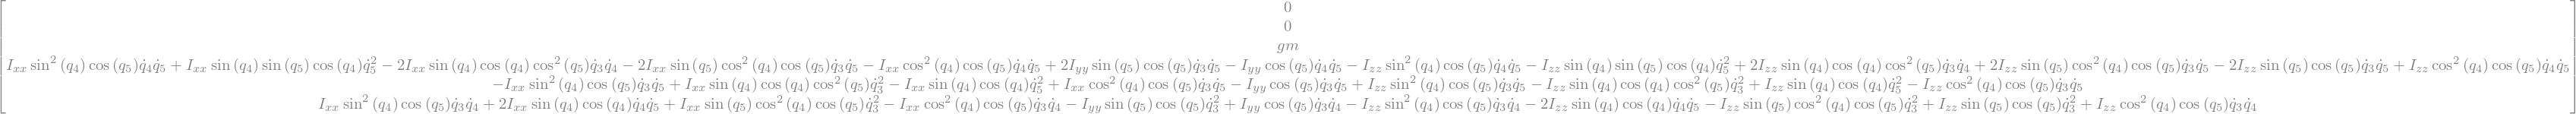

In [56]:
sm.f

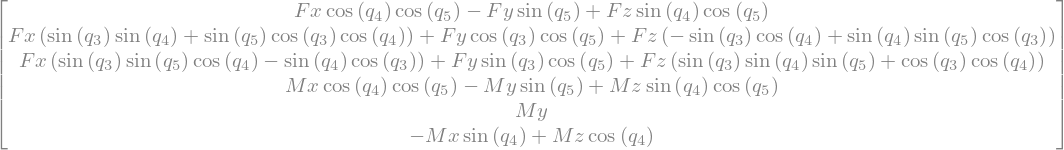

In [57]:
sm.ExtForces.Q()

In [36]:
# to matlab!
file_dir = 'C:\\Git\\AlbatrossOneEoM\\+gen_vlm\\+FreeFlight\\'
sm.to_matlab_file(p,file_dir)

### Create Function to Calculate Body Velocity

In [58]:
v_body = body_frame.Translate(x,y,z).simplify().BodyVelocity()
vb = sym.Matrix(v_body[0:3])

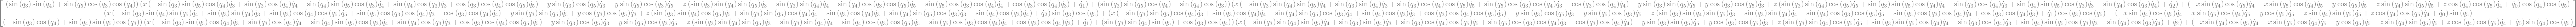

In [59]:
vb

In [38]:
def sm_to_matlab_file(sm,p,expr,func_name,file_dir):
    with open(file_dir+f"{func_name}.m",'w') as file:
        file.write(sm._gen_octave(expr,p,func_name).replace(f'function out = {func_name}(U,p)',f'function out = {func_name}(U,x,y,z,p)'))

In [39]:
file_dir = "C:\\Git\\AlbatrossOneEoM\\+gen_vlm\\+FreeFlight\\"
sm_to_matlab_file(sm,p,vb,'get_V',file_dir)

In [92]:
p.L_1  = ma.ModelSymbol(value = 9.81,string = 'L_1')    
p.L_2  = ma.ModelSymbol(value = 9.81,string = 'L_2')    
test_frame = ma.HomogenousTransform().R_x(p.q[0]).Translate(0,p.L_1,0).R_x(p.q[1]).Translate(0,p.L_2,0)
M = ele.MassMatrix(p.m, I_xx = 0, I_yy=0, I_zz=0)
aircraft_mass = ele.RigidElement(test_frame,M,gravityPotential=True, simplify=True)
aircraft_forces = ef.BodyForce(p,test_frame,Fx=0,Fy=0,Fz=p.Fz,Mx=p.Mx,My=0,Mz=0)
sm = ma.SymbolicModel.FromElementsAndForces(p,[aircraft_mass],ExtForces=aircraft_forces)

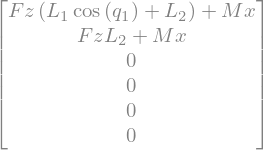

In [93]:
sym.simplify(aircraft_forces.Q())

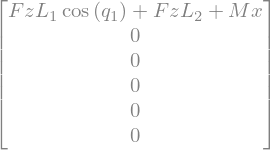

In [94]:
test_frame_1 = ma.HomogenousTransform().R_x(p.q[0]).Translate(0,p.L_1,0)
test_frame_2 = ma.HomogenousTransform().R_x(p.q[1]).Translate(0,p.L_2,0)
# Generate Aircraft external forces
F = test_frame_2.InvAdjoint().T*sym.Matrix([0,0,p.Fz,p.Mx,0,0])
aircraft_forces_tether = ef.BodyForce(p,test_frame_1,Fx=F[0],Fy=F[1],Fz=F[2],Mx=F[3],My=F[4],Mz=F[5])
sym.simplify(aircraft_forces_tether.Q())

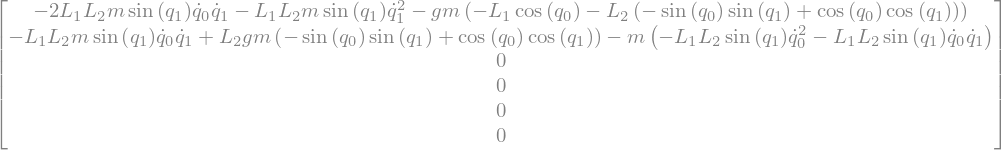

In [96]:
sm.f